# Compton Effekt

## initial imports

In [1]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as con
import uncertainties as un
import uncertainties.unumpy as unp
from scipy.signal import find_peaks,find_peaks_cwt
import scipy.signal as sig
import scipy.special as sp
import scienceplots
plt.figure()
plt.style.use('science')
plt.rcParams['errorbar.capsize'] = 5
# plt.rcParams['text.usetex'] = False # disable latex
plt.rcParams['figure.dpi'] = 150
import os
if not os.path.exists('Compton/output'):
    os.makedirs('Compton/output')

<Figure size 432x288 with 0 Axes>

In [2]:
# normalize
def normalize(arr, t_min, t_max):
    arr = arr.to_numpy()
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr
def simple_norm(arr):
    arr = arr.to_numpy()
    norm_arr = []
    diff = 1
    diff_arr = max(arr) - min(arr)   
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr)
        norm_arr.append(temp)
    return norm_arr
def norm2(arr):
    arr = arr.to_numpy()
    diff_arr = max(arr) - min(arr)   
    return arr/diff_arr

def mapcolors(n):
    """Return a list of n colors from the default colormap"""
    return [plt.cm.jet(int(x*plt.cm.jet.N/n)) for x in range(n)]

## 1 Kalibrierung

### import data

In [3]:
co60_kalib = pd.read_csv('Compton/data/1-Kalibrierung/Co60_kalibr.txt', sep='\t', header=None, names=['channel', 'counts'])
cs137_kalib = pd.read_csv('Compton/data/1-Kalibrierung/Cs137_kalibr.txt', sep='\t', header=None, names=['channel', 'counts'])
na22_kalib = pd.read_csv('Compton/data/1-Kalibrierung/Na22_kalibr.txt', sep='\t', header=None, names=['channel', 'counts'])
kalib_energies = unp.uarray([1173.2,1333,662,511],12)

co60_kalib

,channel,counts
0,0,164
1,1,1012
2,2,908
3,3,924
4,4,941
...,...,...
251,251,14
252,252,14
253,253,17
254,254,6


### analyze data

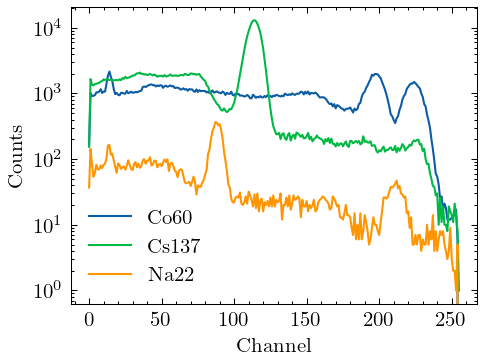

In [4]:
plt.figure()
plt.plot(co60_kalib['channel'], co60_kalib['counts'], label='Co60')
plt.plot(cs137_kalib['channel'], cs137_kalib['counts'], label='Cs137')
plt.plot(na22_kalib['channel'], na22_kalib['counts'], label='Na22')
plt.legend()

plt.xlabel('Channel')
plt.ylabel('Counts')

plt.yscale('log')

array([197, 224])

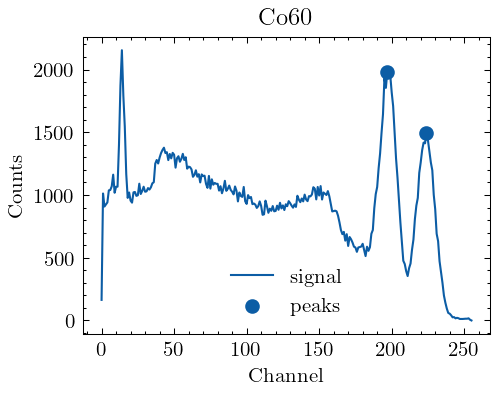

In [5]:
x,y= co60_kalib['channel'], co60_kalib['counts']
plt.figure()
plt.plot(x,y,label='signal')

c60_peaks, _= sig.find_peaks(y, height=1400, distance=20,width=10)
plt.scatter(x[c60_peaks],y[c60_peaks], label='peaks')

plt.title('Co60')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()

c60_peaks

array([114])

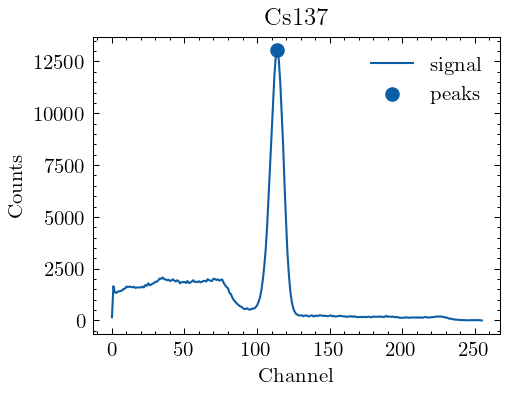

In [6]:
x,y= cs137_kalib['channel'], cs137_kalib['counts']
plt.figure()
plt.plot(x,y,label='signal')

cs137_peaks, _= sig.find_peaks(y, height=4000, distance=20)
plt.scatter(x[cs137_peaks],y[cs137_peaks], label='peaks')

plt.title('Cs137')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()

cs137_peaks

array([87])

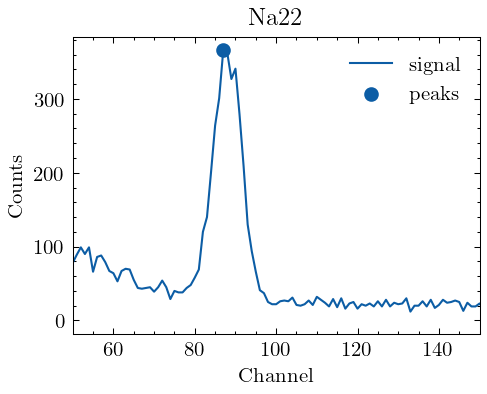

In [7]:
x,y= na22_kalib['channel'],na22_kalib['counts']
plt.figure()
plt.plot(x,y,label='signal')

na22_peaks, _= sig.find_peaks(y, height=200, distance=20)
plt.scatter(x[na22_peaks],y[na22_peaks], label='peaks')
plt.xlim(50,150)

plt.title('Na22')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()

na22_peaks

In [8]:
def linfit(x,a,b):
    return a*x+b

In [9]:
kalib_channels = np.array([])
kalib_channels = np.append(kalib_channels,c60_peaks)
kalib_channels = np.append(kalib_channels,cs137_peaks)
kalib_channels = np.append(kalib_channels,na22_peaks)
kalib_channels = unp.uarray(kalib_channels, 2)
kalib_channels,kalib_energies

(array([197.0+/-2.0, 224.0+/-2.0, 114.0+/-2.0, 87.0+/-2.0], dtype=object),
 array([1173.2+/-12.0, 1333.0+/-12.0, 662.0+/-12.0, 511.0+/-12.0],
       dtype=object))

a = 6.04(6)keV/chn 	 b = -20+/-9keV


Text(0, 0.5, 'Energie [keV]')

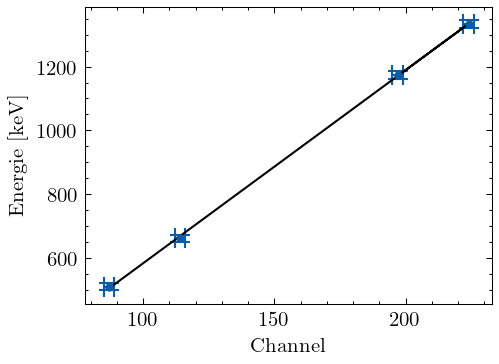

In [10]:
x ,y = unp.nominal_values(kalib_channels),unp.nominal_values(kalib_energies)
xerr,yerr = unp.std_devs(kalib_channels),unp.std_devs(kalib_energies)
plt.figure()
plt.errorbar(x,y,yerr,xerr,fmt='.',label='data')

c,cov = curve_fit(linfit,x,y,sigma=yerr)
perr=np.sqrt(np.diag(cov))
plt.plot(x,linfit(x,*c),label='fit',c='k')

a = unp.uarray(c[0],perr[0])
b = unp.uarray(c[1],perr[1])
print(f'a = {a:S}keV/chn \t b = {b}keV')

def energy(channel):
    return a*channel+b

plt.xlabel('Channel')
plt.ylabel('Energie [keV]')

In [11]:
e0 = con.electron_mass*con.c**2
def radian(angle):
    return angle*np.pi/180
def degree(angle):
    return angle*180/np.pi
def joule(kev):
    return kev*1e3*con.e
def kev(joule):
    return joule/(1e3*con.e)
def photon_energy(initial_energy, angle):
    return initial_energy/(1+initial_energy/e0*(1-np.cos(angle)))
def electron_energy(initial_energy, angle):
    return initial_energy - photon_energy(initial_energy, angle)
def compton_angle(initial_energy, angle):
    return np.arccos(1-2*photon_energy(initial_energy, angle)/initial_energy)

In [12]:
phi = radian(180)
kalib_sources = ['Co60','Co60', 'Cs137', 'Na22']
for s , e in zip(kalib_sources, kalib_energies):

    print(f'{s} Rad:\t{e:S}keV \t->\tPhoton: {kev(photon_energy(joule(e),phi)):S}keV\tElectron: {kev(electron_energy(joule(e),phi)):S}keV')

Co60 Rad:	1173(12)keV 	->	Photon: 209.8(4)keV	Electron: 963(12)keV
Co60 Rad:	1333(12)keV 	->	Photon: 214.40(31)keV	Electron: 1119(12)keV
Cs137 Rad:	662(12)keV 	->	Photon: 184.3(9)keV	Electron: 478(11)keV
Na22 Rad:	511(12)keV 	->	Photon: 170.3(1.3)keV	Electron: 341(11)keV


Text(0, 0.5, 'Energie [keV]')

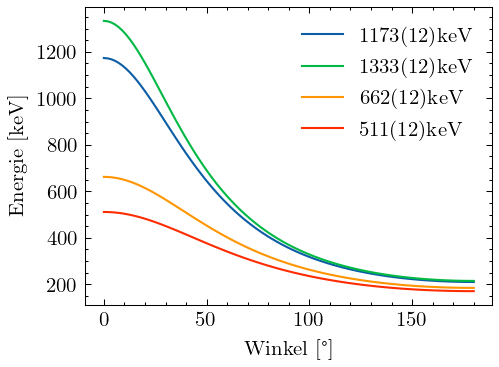

In [13]:
phi = radian(np.linspace(0,180,100))
for e in kalib_energies:
    plt.plot(degree(phi),kev(photon_energy(joule(e.n),phi)),label=f'{e:S}keV')
plt.legend()

plt.xlabel('Winkel [°]')
plt.ylabel('Energie [keV]')

## 2 Streuwinkel

### import data

In [14]:
streuwinkel = [0,10, 30, 50, 70, 90, 110,130]
streuwinkel = unp.uarray(streuwinkel,0.5)
streu_data = []*len(streuwinkel)
for i in streuwinkel:
    streu_data.append(pd.read_csv(f'Compton/data/2-Comptonspektrum/{int(i.n)}_grad.txt', sep='\t', header=None, names=['channel', 'counts']))
streu_data[len(streu_data)-1]

,channel,counts
0,0,21
1,1,89
2,2,33
3,3,21
4,4,38
...,...,...
251,251,4
252,252,1
253,253,1
254,254,2


### analyze data

Text(0, 0.5, 'Counts')

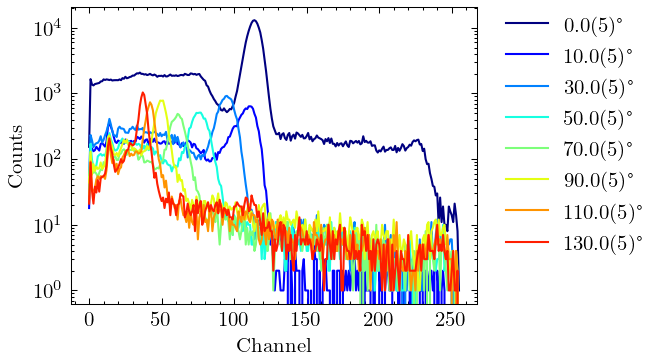

In [15]:
plt.figure()
for i in range(len(streu_data)):
    plt.plot(streu_data[i]['channel'], streu_data[i]['counts'], label=f'{streuwinkel[i]:S}°',color=mapcolors(len(streu_data))[i])
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1)


plt.xlabel('Channel')
plt.ylabel('Counts')

## 3 Rückstoßelektronen

### import data

In [16]:
rueckstoss_data = pd.read_csv('Compton/data/3-Elektronenstreuung/elektronspektr.txt', sep='\t', header=None, names=['channel', 'counts'])

### analyze data

Text(0, 0.5, 'Counts')

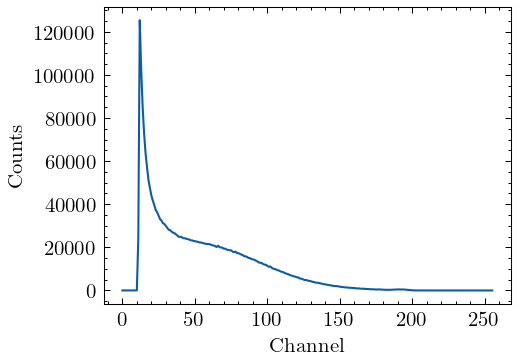

In [17]:
plt.figure()
plt.plot(rueckstoss_data['channel'], rueckstoss_data['counts'], label='Rückstosselektronen')

plt.xlabel('Channel')
plt.ylabel('Counts')

Count = -1.255(9)e+04 * erf(0.02050(23)*(channel-94.58(23))) + 1.297(5)e+04
Comptonkante = 94.58(23)


Text(0, 0.5, 'Counts')

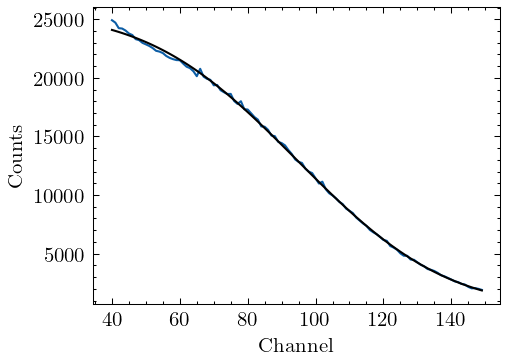

In [18]:
plt.figure()
xmin,xmax = 40,150
x,y = rueckstoss_data['channel'][xmin:xmax], rueckstoss_data['counts'][xmin:xmax]
plt.plot(x,y, label='Rückstosselektronen')

# fit with error function
def erf(x,a,b,c,d):
    return a*sp.erf(b*(x-c))+d

popt,pcov = curve_fit(erf,x,y,p0=[-10000,0.01,100,10000],sigma=np.sqrt(y))
perr = np.sqrt(np.diag(pcov))
plt.plot(x,erf(x,*popt),label='fit',c='k')
c = unp.uarray(popt,perr)
print(f'Count = {c[0]:S} * erf({c[1]:S}*(channel-{c[2]:S})) + {c[3]:S}')
compton_kante = c[2]
print(f"Comptonkante = {compton_kante:S}")

def e_energy(channel):
    return kev(electron_energy(joule(kalib_energies[3]),np.deg2rad(180)))*channel/compton_kante

plt.xlabel('Channel')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

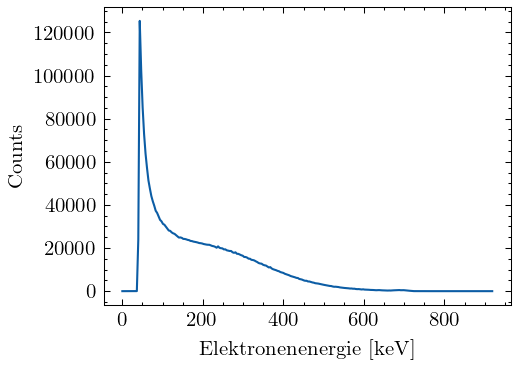

In [19]:
plt.figure()
plt.plot(unp.nominal_values(e_energy(rueckstoss_data['channel'])), rueckstoss_data['counts'], label='Rückstosselektronen')

plt.xlabel('Elektronenenergie [keV]')
plt.ylabel('Counts')

## 4 Koinzidenz

### import data

In [20]:
koinzidenz_winkel = [50,70,90,110,130]
koinzidenz_winkel = unp.uarray(koinzidenz_winkel,0.5)
koinzidenz_data = []*len(koinzidenz_winkel)
for i in koinzidenz_winkel:
    koinzidenz_data.append(pd.read_csv(f'Compton/data/4-Koinzidenz/{int(i.n)}_grad.txt', sep='\t', header=None, names=['channel', 'count']))
koinzidenz_data[0]

,channel,count
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
251,251,0
252,252,0
253,253,0
254,254,0


### analyze data

Text(0, 0.5, 'Count')

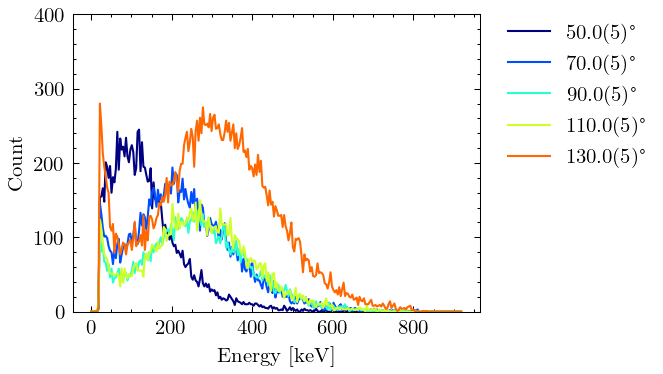

In [21]:
plt.figure()
for i in range(len(koinzidenz_data)):
    x,y= e_energy(koinzidenz_data[0]['channel']), koinzidenz_data[i]['count']
    plt.plot(unp.nominal_values(x),y, label=f'{koinzidenz_winkel[i]:S}°',color=mapcolors(len(koinzidenz_data))[i])
# plt.yscale('log')
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.ylim(0,400)
# plt.xlim(0,200)
plt.xlabel('Energy [keV]')
plt.ylabel('Count')


## 5 Energien der Photopeaks

0.0(5)°: 669(11)keV
10.0(5)°: 651(11)keV
30.0(5)°: 554(11)keV
50.0(5)°: 445(10)keV
70.0(5)°: 349(10)keV
90.0(5)°: 288(10)keV
110.0(5)°: 234(10)keV
130.0(5)°: 204(10)keV


Text(0.5, 0, 'Energie [keV]')

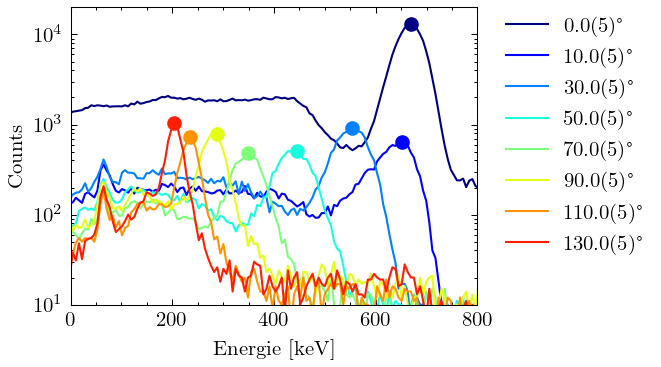

In [22]:
streu_energies = np.array([])
plt.figure()
for i in range(len(streu_data)):
    x,y = energy(streu_data[i]['channel']), streu_data[i]['counts']
    plt.plot(unp.nominal_values(x),y, label=f'{streuwinkel[i]:S}°',color=mapcolors(len(streu_data))[i])
    peaks, _= sig.find_peaks(y, height=100, distance=20,width=5,prominence=max(y)/5)
    plt.scatter(unp.nominal_values(x[peaks]),y[peaks], color=mapcolors(len(streu_data))[i])
    if (len(peaks)==1):
        print(f'{streuwinkel[i]:S}°: {energy(peaks[0]):S}keV')
        streu_energies = np.append(streu_energies,energy(peaks[0]))
    elif (len(peaks)==0):
        print(f'{streuwinkel[i]:S}°: no peak found')
    else:
        print(f'{streuwinkel[i]:S}°: too many peaks ({len(peaks)})')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=1)
plt.xlim(0,800)
plt.ylim(10,20000)
plt.ylabel('Counts')
plt.xlabel('Energie [keV]')

Text(0, 0.5, 'Energie [keV]')

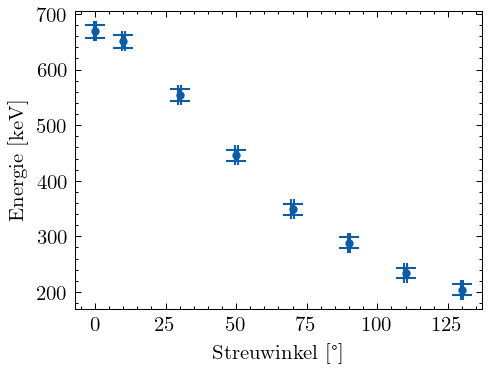

In [23]:
plt.figure()
plt.errorbar(unp.nominal_values(streuwinkel),unp.nominal_values(streu_energies),unp.std_devs(streu_energies),unp.std_devs(streuwinkel),fmt='.',label='data')
plt.xlabel('Streuwinkel [°]')
plt.ylabel('Energie [keV]')

50.0(5)°: 137(10)keV
70.0(5)°: 331(10)keV
90.0(5)°: 397(10)keV
110.0(5)°: 421(10)keV
130.0(5)°: 500(11)keV


Text(0, 0.5, 'Count')

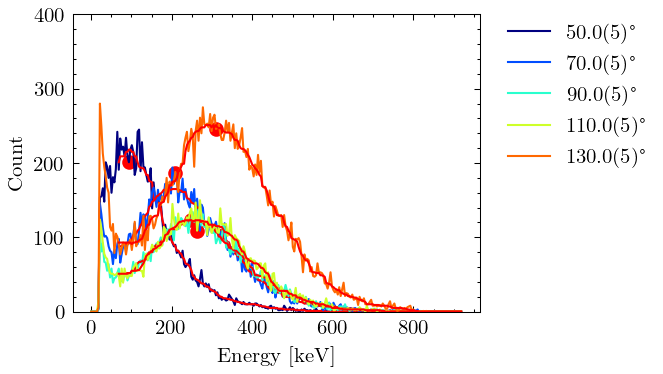

In [24]:
w = 19
electron_energies = np.array([])
electron_angles = np.array([])
plt.figure()
for i in range(len(koinzidenz_data)):
    x,y= e_energy(koinzidenz_data[0]['channel']), koinzidenz_data[i]['count']
    plt.plot(unp.nominal_values(x),y, label=f'{koinzidenz_winkel[i]:S}°',color=mapcolors(len(koinzidenz_data))[i])
    ym = sig.medfilt(y, w)
    plt.plot(unp.nominal_values(x[w:]),ym[w:], color='r')
    peaks, _= sig.find_peaks(ym, height=10, distance=20)
    if (len(peaks) != 0):
        print(f'{koinzidenz_winkel[i]:S}°: {energy(peaks[-1]):S}keV')
        plt.scatter(unp.nominal_values(x[peaks[-1]]),y[peaks[-1]], color='r')
        electron_energies = np.append(electron_energies,energy(peaks[-1]))
        electron_angles = np.append(electron_angles,koinzidenz_winkel[i])
# plt.yscale('log')
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.ylim(0,400)
# plt.xlim(0,200)
plt.xlabel('Energy [keV]')
plt.ylabel('Count')

Text(0, 0.5, 'Energie [keV]')

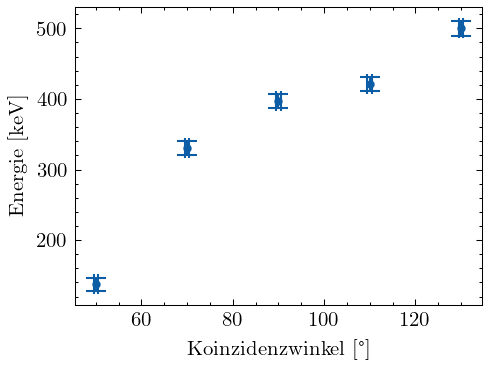

In [25]:
plt.figure()
plt.errorbar(unp.nominal_values(electron_angles),unp.nominal_values(electron_energies),unp.std_devs(electron_energies),unp.std_devs(electron_angles),fmt='.',label='data')
plt.xlabel('Koinzidenzwinkel [°]')
plt.ylabel('Energie [keV]')

50.0(5)°: 137(10) + 445(10)keV = 583(20)keV
70.0(5)°: 331(10) + 349(10)keV = 679(20)keV
90.0(5)°: 397(10) + 288(10)keV = 685(20)keV
110.0(5)°: 421(10) + 234(10)keV = 655(20)keV
130.0(5)°: 500(11) + 204(10)keV = 704(20)keV
Energy of the sum: 661(21)keV


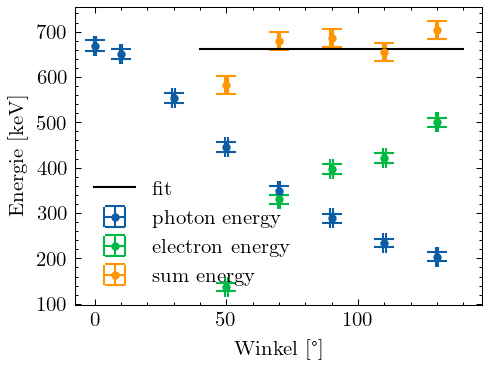

In [26]:
def const(x,a):
    return a*np.ones(len(x))

plt.figure()
plt.errorbar(unp.nominal_values(streuwinkel),unp.nominal_values(streu_energies),unp.std_devs(streu_energies),unp.std_devs(streuwinkel),fmt='.',label='photon energy')
plt.errorbar(unp.nominal_values(electron_angles),unp.nominal_values(electron_energies),unp.std_devs(electron_energies),unp.std_devs(electron_angles),fmt='.',label='electron energy')

# add values with same angl
sum_energies = np.array([])
for i in range(len(electron_angles)):
    for j in range(len(streuwinkel)):
        if (electron_angles[i].n == streuwinkel[j].n):
            print(f'{electron_angles[i]:S}°: {electron_energies[i]:S} + {streu_energies[j]:S}keV = {electron_energies[i]+streu_energies[j]:S}keV')
            sum_energies = np.append(sum_energies,electron_energies[i]+streu_energies[j])

plt.errorbar(unp.nominal_values(electron_angles),unp.nominal_values(sum_energies),unp.std_devs(sum_energies),unp.std_devs(electron_angles),fmt='.',label='sum energy')

xl = np.linspace(40,140,100)
popt, pcov = curve_fit(const,unp.nominal_values(electron_angles),unp.nominal_values(sum_energies),sigma=unp.std_devs(sum_energies))
plt.plot(xl,const(xl,*popt),label='fit',c='k')
sum_energy = un.ufloat(popt[0],np.sqrt(pcov[0][0]))
print(f'Energy of the sum: {sum_energy:S}keV')

plt.xlabel('Winkel [°]')
plt.ylabel('Energie [keV]')
plt.legend()

## 6 Ruhemasse des Elektrons

1/E = 2.051(29)(1-cos(\theta) + 1.506(8)
m_e = 8.69(12)e-31kg
lit. m_e = 9.1093837015e-31kg


Text(0, 0.5, 'Reziproke Energie [1/MeV]')

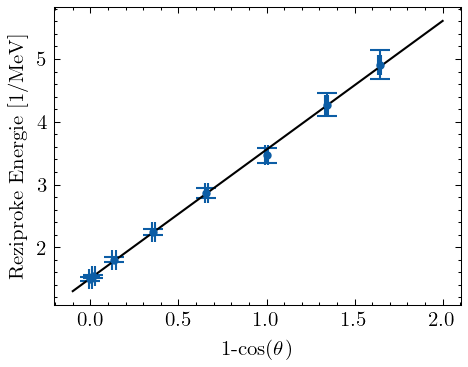

In [27]:
rez_energies = 1/streu_energies*1e3
x = unp.uarray(1-np.cos(np.deg2rad(unp.nominal_values(streuwinkel))),np.deg2rad(unp.std_devs(streuwinkel)))
plt.figure()
plt.errorbar(unp.nominal_values(x),unp.nominal_values(rez_energies),unp.std_devs(rez_energies),unp.std_devs(x),fmt='.',label='data')

xl = np.linspace(-0.1,2,100)
c, cov = curve_fit(linfit,unp.nominal_values(x),unp.nominal_values(rez_energies),sigma=unp.std_devs(rez_energies))
plt.plot(xl,linfit(xl,*c),label='fit',color='k')
a = un.ufloat(c[0],np.sqrt(cov[0][0]))
b = un.ufloat(c[1],np.sqrt(cov[1][1]))

print(rf'1/E = {a:S}(1-cos(\theta) + {b:S}')
m_e = 1/(con.c**2*a*1e-6/con.e)
print(f'm_e = {m_e:S}kg')
print(f'lit. m_e = {con.m_e}kg')

plt.xlabel(r'1-cos($\theta$)')
plt.ylabel('Reziproke Energie [1/MeV]')

In [28]:
def radius(m_e):
    return con.e**2/(m_e*con.c**2*4*con.pi*con.epsilon_0)

print(m_e)
print(con.m_e)

print(f'Radius of the electron: {radius(m_e):S}m')
print(f'lit. Radius: {radius(con.m_e)}m')

(8.69+/-0.12)e-31
9.1093837015e-31
Radius of the electron: 2.95(4)e-15m
lit. Radius: 2.817940326204929e-15m
